In [1]:
import os
import numpy as np
import cv2 as cv
from scipy.stats import loguniform, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# read data
nomask_path = "D:\\Code_uc\\face_reco\\output\\dataset_nomask"
mask_path = "D:\\Code_uc\\face_reco\\output\\dataset_mask"
ag_nomask_path = "D:\\Code_uc\\face_reco\\output\\augment_nomask"
ag_mask_path = "D:\\Code_uc\\face_reco\\output\\augment_mask"
X = []
y_multi = []
for i, subject_name in enumerate(os.listdir(mask_path)):
    subject_images_dir = os.path.join(mask_path, subject_name)
    y_multi.extend([int(subject_name[1:])]*15)
    for img_name in os.listdir(subject_images_dir):
        img_path = os.path.join(subject_images_dir, img_name)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        # img = np.reshape(img, [-1]) 
        X.append(img)
X = np.asarray(X)
y = np.asarray([1] * 450 + [0] * 300) # change this

In [3]:
X_train, X_ac, y_train, y_ac = train_test_split(X[:600], y_multi[:600])
X_rj = X[600:]
gamma = 0.4
look_up_table = np.arange(256, dtype=np.float32)
look_up_table = (look_up_table/255.0)**gamma * 255
look_up_table = np.clip(look_up_table, 0, 255)

In [4]:
def data_augmentation(X):
    aug_imgs_1 = []
    aug_imgs_2 = []
    aug_imgs_3 = []
    for img in X:
        img_1 = np.roll(img, 5, axis=1)
        img_2 = np.roll(img, -5, axis=1)
        img_3 = cv.LUT(img, look_up_table)
        img_3 = img_3.astype(np.uint8)
        aug_imgs_1.append(img_1)
        aug_imgs_2.append(img_2)
        aug_imgs_3.append(img_3)
    aug_imgs_1 = np.asarray(aug_imgs_1)
    aug_imgs_2 = np.asarray(aug_imgs_2)
    aug_imgs_3 = np.asarray(aug_imgs_3)
    return np.vstack([X, aug_imgs_1, aug_imgs_2, aug_imgs_3])

In [5]:
X_train = data_augmentation(X_train)
X_ac = data_augmentation(X_ac)
X_rj = data_augmentation(X_rj)
y_ac = y_ac * 4
y_train = y_train * 4

In [6]:
X_train = X_train.reshape([X_train.shape[0], -1])
X_ac = X_ac.reshape([X_ac.shape[0], -1])
X_rj = X_rj.reshape([X_rj.shape[0], -1])

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_ac = scaler.transform(X_ac)
X_rj = scaler.transform(X_rj)
pca = PCA(n_components=50, svd_solver="randomized", whiten=True)
pca.fit(X_train)
X_train_trans = pca.transform(X_train)
X_ac_trans = pca.transform(X_ac)
X_rj_trans = pca.transform(X_rj)

In [8]:
# feature transformation: LDA
# lda = LDA(n_components=29)
# lda.fit(X_train, y_train)
# X_train_lda = lda.transform(X_train)
# X_ac_lda = lda.transform(X_ac)
# X_rj_lda = lda.transform(X_rj)
# X_train_trans = np.hstack([X_train_trans, X_train_lda])
# X_ac_trans = np.hstack([X_ac_trans, X_ac_lda])
# X_rj_trans = np.hstack([X_rj_trans, X_rj_lda])

In [20]:
clf = SVC(C=1, kernel="rbf", probability=True)
clf.fit(X_train_trans, y_train)
clf.score(X_ac_trans, y_ac)

0.7683333333333333

In [21]:
clf.gamma

'scale'

In [17]:
param_grid = {
    "C": loguniform(1, 1e3),
    "gamma": loguniform(1e-6, 1e-1),
}
opt_clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced", probability=True), param_grid, n_iter=10
)
opt_clf = opt_clf.fit(X_train_trans, y_train)

In [23]:
eval_clf = opt_clf
prob_rj, prob_ac = eval_clf.predict_proba(X_rj_trans), eval_clf.predict_proba(X_ac_trans)
max_prob_rj = np.max(prob_rj, axis=1)
max_prob_ac = np.max(prob_ac, axis=1)
num_rj = np.count_nonzero(max_prob_rj < 0.4)
num_ac = np.count_nonzero(max_prob_ac > 0.4)

print(num_rj, num_ac)
print(eval_clf.score(X_ac_trans, y_ac))
print(eval_clf.best_estimator_)

495 387
0.7866666666666666
SVC(C=229.83966753397146, class_weight='balanced', gamma=0.004163590164587884,
    probability=True)


In [12]:
entropy_ac = []
entropy_rj = []
for prob in prob_ac:
    entropy_ac.append(entropy(prob))
for prob in prob_rj:
    entropy_rj.append(entropy(prob))

entropy_ac, entropy_rj = np.asarray(entropy_ac), np.asarray(entropy_rj)

In [13]:
num_ac = np.count_nonzero(entropy_ac < 2.5)
num_rj = np.count_nonzero(entropy_rj > 2.5)
print(num_ac, num_rj)

408 459


In [14]:
from sklearn.metrics import accuracy_score
y_pred = eval_clf.predict(X_train_trans)
accuracy_score(y_train, y_pred)
y_pred_ac = eval_clf.predict(X_ac_trans)
# considerable performance drop & very high training set accuracy

0.9988888888888889

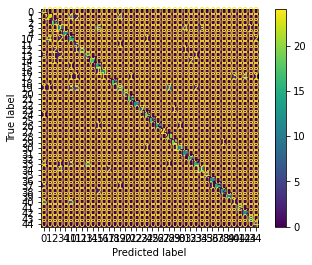

In [28]:
from dis import dis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_ac = eval_clf.predict(X_ac_trans)
cf_mat = confusion_matrix(y_ac, y_pred_ac)
disp = ConfusionMatrixDisplay(cf_mat, display_labels=eval_clf.classes_)
disp.plot()
plt.show()